In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# CONSTANTS
N_HIST_BINS = 100
E_CHARGE = 1.60217662E-19
NEG_CHARGE = -0.20E-12

# FUNCTIONS / GAUSSIANS
def gauss(x, mean, sd, n):
    return (n/(np.sqrt(2*np.pi)*sd))*np.exp(-(x - mean)**2/(2*sd**2))

def double_gauss(x, mean, sd, n):
    return (gauss(x, popt_ped[0], popt_ped[1], popt_ped[2]) + 
            (n/(np.sqrt(2*np.pi)*sd))*np.exp(-(x - mean)**2/(2*sd**2)))

# def triple_gauss(x, mean, sd, n):
#     return (gauss(x, popt_ped[0], popt_ped[1], popt_ped[2]) + 
#             gauss(x, popt_1pe[0], popt_1pe[1], popt_ped[2]) + 
#             (n/(np.sqrt(2*np.pi)*sd))*np.exp(-(x - mean)**2/(2*sd**2)))

def triple_gauss(x, m1, sd1, n1, m2, sd2, n2, m3, sd3, n3):
    return ((n1/(np.sqrt(2*np.pi)*sd1))*np.exp(-(x - m1)**2/(2*sd1**2)) + 
            (n2/(np.sqrt(2*np.pi)*sd2))*np.exp(-(x - m2)**2/(2*sd2**2)) + 
            (n3/(np.sqrt(2*np.pi)*sd3))*np.exp(-(x - m3)**2/(2*sd3**2)))

def gain_curve(volt, m, b):
    return m*volt + b

# def gain_curve(volt, a, m, b):
#     return a*np.exp(m*volt) + b

%matplotlib inline

In [4]:
# LOAD DATA FILE
with open('dgz_test/my_charges_neg.txt') as f:
    charge = np.loadtxt(f, dtype=float)

# SKIPPING VERY NEGATIVE CHARGE VALUES (EARLY PULSES)
# i=0
# new_charge = []

# while (i < len(charge)):
#     if (charge[i] < NEG_CHARGE):
# #        continue
#         print("skipped " + str(charge[i]))
#     else:
#         new_charge.append(charge[i])
#     i+=1

# new_charge = np.array(new_charge)

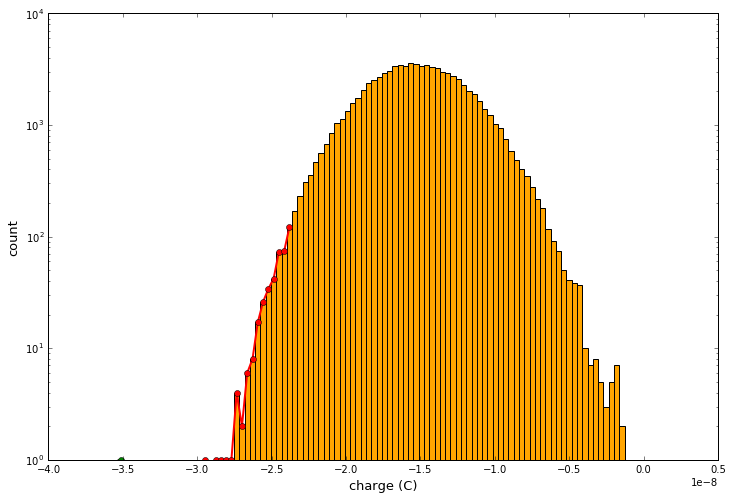

In [5]:
BIN_START = 0
BIN_END_PT = 14
DELTA = 0
EXTRA = 19 #len(new_charge) - BIN_START - BIN_END_PT - DELTA


### plotting 
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
plt.yscale('log', nonposy='clip')
plt.xlabel('charge (C)', fontsize=13)
plt.ylabel('count', fontsize=13)
# plt.xlim(-0.2E-11, 0.6E-11)

ydata, bins, patches = ax1.hist(charge, bins=N_HIST_BINS, 
                                 facecolor='orange')

bins = 1E12*bins
bin_centers = np.array(bins[:-1]+(bins[1]-bins[0])/2.0)

plt.plot(bin_centers[BIN_START:BIN_END_PT]*1E-12, ydata[BIN_START:BIN_END_PT], lw='2', marker='o')
plt.plot(bin_centers[BIN_END_PT+DELTA:BIN_END_PT+DELTA+EXTRA]*1E-12, ydata[BIN_END_PT+DELTA:BIN_END_PT+DELTA+EXTRA], 
         lw='2', marker='o')

In [72]:
# BIN UNCERTAINTIES USING SQRT OF N

# bins = 1E12*bins
# bin_centers = np.array(bins[:-1]+(bins[1]-bins[0])/2.0)

uncert_data = []
for i in range(ydata.size):
    uncert_data.append(np.sqrt(ydata[i]))
    if uncert_data[i] == 0:
        uncert_data[i] = 1

In [73]:
# FIT PEDESTAL; p0=[mean, sd, normalization const]
popt_ped, pcov_ped = curve_fit(gauss, bin_centers[BIN_START:BIN_END_PT],
                               ydata[BIN_START:BIN_END_PT], p0=[0, 0.5, 2500], 
                               sigma=uncert_data[BIN_START:BIN_END_PT])
# FIT 1PE PEAK SEPARATELY
popt_1pe, pcov_1pe = curve_fit(gauss, bin_centers[BIN_END_PT+DELTA:BIN_END_PT+DELTA+EXTRA],
                               ydata[BIN_END_PT+DELTA:BIN_END_PT+DELTA+EXTRA], p0=[1.5, 1, 350],
                               sigma=uncert_data[BIN_END_PT+DELTA:BIN_END_PT+DELTA+EXTRA])
# FIT 1PE PEAK W/ PEDESTAL
popt_spe, pcov_spe = curve_fit(double_gauss, bin_centers, ydata, p0=[1.5, 2, 300],
                             sigma=uncert_data)

# FIT 2PE PEAK W/ PEDESTAL & 1PE PEAK
# popt_2pe, pcov_2pe = curve_fit(triple_gauss, bin_centers, ydata, p0=[3, 2, 150], 
#                               sigma=uncert_data)

popt_trg, pcov_trg = curve_fit(triple_gauss, bin_centers, ydata, 
                               p0=[popt_ped[0], popt_ped[1], popt_ped[2], popt_1pe[0], popt_1pe[1], popt_1pe[2], 3.0, 1, 200], 
                               sigma=uncert_data)

#FIT 2PE PEAK SEPARATELY
# popt_2pe, pcov_2pe = curve_fit(gauss, bin_centers[BIN_END_PT+DELTA+EXTRA:],
#                                ydata[BIN_END_PT+DELTA+EXTRA:], p0=[1.75, 2, 175],
#                                sigma=uncert_data[BIN_END_PT+DELTA+EXTRA:])


print(popt_ped)
# print(popt_spe)
print(popt_1pe)
print(popt_2pe)
print(popt_trg)

[ -1.86034178e-02   2.34743881e-01   1.24901741e+03]
[  1.60722305e+00   7.33145286e-01   1.04204378e+03]
[   3.97009433    0.98745425  253.86165358]
[ -3.39610512e-02   2.21197906e-01   1.18159473e+03   1.51610208e+00
   6.38568208e-01   7.80057447e+02   3.03820972e+00   1.40273551e+00
   5.23703457e+02]


In [74]:
ped_fit = gauss(bin_centers, *popt_ped)
pe_fit = gauss(bin_centers, *popt_1pe)
db_fit = double_gauss(bin_centers, *popt_spe)
tr_fit = triple_gauss(bin_centers, *popt_trg)

bin_centers = bin_centers*1E-12

print("double gauss: " + str((popt_spe[0]-popt_ped[0])*1E-12/E_CHARGE))
print("separate fit: " + str((popt_1pe[0]-popt_ped[0])*1E-12/E_CHARGE))
print("triple gauss: " + str((popt_trg[6]-popt_trg[3])*1E-12/E_CHARGE))
print((popt_trg[3]-popt_trg[0])*1E-12/E_CHARGE)

double gauss: 12009690.445
separate fit: 10147610.7263
triple gauss: 9500248.77921
9674733.15569


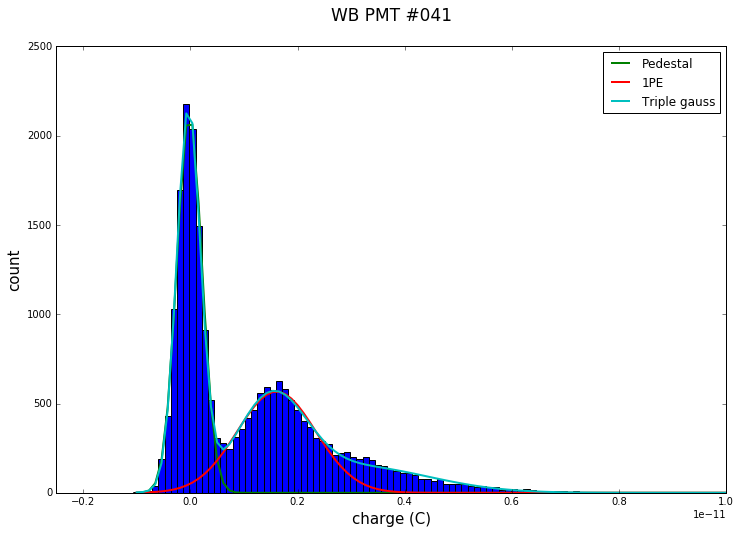

In [75]:
plt.figure(figsize=(12,8))
plt.title('WB PMT #041\n', fontsize=17)
plt.xlabel('charge (C)', fontsize=15)
plt.ylabel('count', fontsize=15)
# plt.yscale('log')

plt.hist(new_charge, bins=N_HIST_BINS)
plt.plot(bin_centers, ped_fit, label='Pedestal', lw='2')
plt.plot(bin_centers, pe_fit, label='1PE', lw='2')
# plt.plot(bin_centers, db_fit, label='Double', lw='2')
plt.plot(bin_centers, tr_fit, label='Triple gauss', lw='2')
# plt.plot(popt_spe[0]*1E-12, 875, label='DF Mean', marker='o')
# plt.plot(popt_1pe[0]*1E-12, 875, label='SF Mean', marker='o')
# plt.plot(popt_trg[6]*1E-12, 875, label='TF Mean', marker='o')


plt.xlim(-0.25e-11, 1.0e-11)
plt.legend(loc=0)
plt.savefig("WB041_fits.png")

In [99]:
# PEAK-TO-VALLEY RATIO

ped_i = 0
spe_i = 0
spe_peak = max(ydata[BIN_END_PT:BIN_END_PT+EXTRA])
print("PE peak: " + str(spe_peak))

for i in range(50):
    if (ydata[i] == max(ydata[0:50])):
        ped_i = i
    elif (ydata[i] == spe_peak):
        spe_i = i

valley = min(ydata[ped_i:spe_i])
print("Valley: " + str(valley))

p2v = spe_peak/valley
print(p2v)

PE peak: 634.0
Valley: 275.0
2.30545454545


In [33]:
# GAIN UNCERTAINTY
uncert_gain = gain/np.sqrt(popt_1pe[2]) # using single fit; not sure if this is correct


##########################
# CHI SQ
chi_sq = 0 # individual fit
counter = 0

# for pedestal portion
for i in range(ydata[:BIN_END_PT].size):
    chi_sq += (ydata[i] - ped_fit[i])**2/(uncert_data[i]**2)
    counter+=1
print(chi_sq)

# for the rest of the data
for i in range(ydata[BIN_END_PT:].size):
    chi_sq += (ydata[BIN_END_PT+i] - pe_fit[BIN_END_PT+i])**2/(uncert_data[BIN_END_PT+i]**2)
    counter+=1
print(chi_sq)

# for i in range(ydata.size):
#     chi_sq += (ydata[i] - db_fit[i])**2/(uncert_data[i]**2)
#     counter+=1
# print(chi_sq)

print(counter)
print((BIN_END_PT-BIN_START) + (EXTRA-DELTA))
red_chi_sq = chi_sq/((BIN_END_PT-BIN_START) + (EXTRA-DELTA) - 6) # why subtract 6? 6 parameters
# red_chi_sq = chi_sq/(len(bin_centers) - 6)


##########################
# STATS
print("gain: " + str(gain) + " +/- " + str(uncert_gain))
print("pedestal mean: " + str(popt_ped[0]))
print("pedestal std dev: " + str(popt_ped[1]))
print("pedestal norm const: " + str(popt_ped[2]))
print("p.e. mean: " + str(popt_1pe[0]))
print("p.e. std dev: " + str(popt_1pe[1]))
print("p.e. norm const: " + str(popt_1pe[2]))
print("chi sq: " + str(chi_sq))
print("reduced chi sq: " + str(red_chi_sq))
print("p.e. mean (double fit): " + str(popt_spe[0]))
print("gain (double fit): " + str(gain2))


# WRITE TO FILE
f2 = open("WB045_stats.txt", 'w')
f2.write("WB PMT #045" + "\n")
f2.write("operating voltage: 1444 V" + "\n")
f2.write("gain: " + str(gain) + " +/- " + str(uncert_gain) + "\n")
f2.write("pedestal mean: " + str(popt_ped[0]) + "\n")
f2.write("pedestal std dev: " + str(popt_ped[1]) + "\n")
f2.write("pedestal norm const: " + str(popt_ped[2]) + "\n")
f2.write("p.e. mean: " + str(popt_1pe[0]) + "\n")
f2.write("p.e. std dev: " + str(popt_1pe[1]) + "\n")
f2.write("p.e. norm const: " + str(popt_1pe[2]) + "\n")
f2.write("chi sq: " + str(chi_sq) + "\n")
f2.write("reduced chi sq: " + str(red_chi_sq) + "\n\n")
f2.write("p.e. mean (double fit): " + str(popt_spe[0]) + "\n")
f2.write("gain (double fit): " + str(gain2))
f2.close()

112.922795443
2484.44055892
100
29
gain: 10396735.3309 +/- 285275.843274
pedestal mean: -0.0324043071326
pedestal std dev: 0.233047355299
pedestal norm const: 1423.85053641
p.e. mean: 1.63333632002
p.e. std dev: 0.703544636113
p.e. norm const: 1328.20154466
chi sq: 2484.44055892
reduced chi sq: 108.019154736
p.e. mean (double fit): 1.89827154376
gain (double fit): 12050330.9485


_________________________________________________________________________________________________

_________________________________________________________________________________________________

_________________________________________________________________________________________________

In [ ]:
# print(ydata)
# print(bins)

# es igual
# ydata2, bins2, patches2 = plt.hist(new_charge, bins=N_HIST_BINS, 
#                                     facecolor='orange')

# testing to see if bin edges were in order; they are
j=0
while (j < (len(bins))):
    if (bins[j-1] > bins[j]):
        print("oh no!")
    j+=1

-------------------------------------------------------------------------------------------------

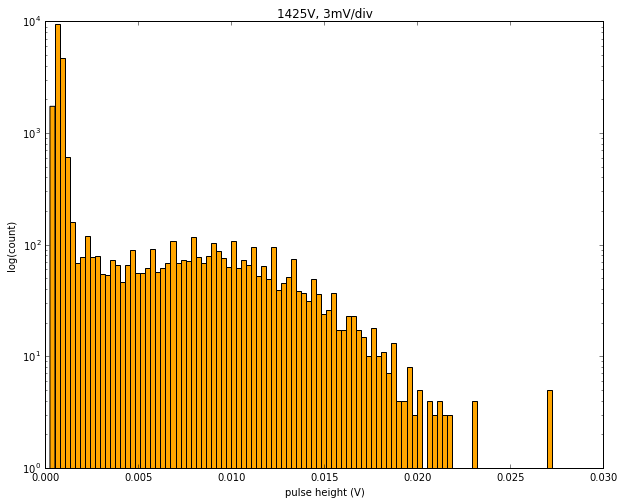

In [39]:
plt.figure(figsize=(10,8))
plt.yscale('log')
plt.xlabel("pulse height (V)")
plt.ylabel("log(count)")
plt.title("1425V, 3mV/div")
pulse_ht, pulse_bin, ppatches = plt.hist(pulse_heights, bins=N_HIST_BINS, facecolor='orange')
# plt.savefig("pulseHt_3mV_log.png")

### Dark noise

In [133]:
30807/20

1540

### Gain curve

In [35]:
voltages = np.array([1330, 1370])
gain = np.array([0.83E7, 1.2E7])

[ 0.00400258  1.59564823]


/usr/lib/python2.7/dist-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


1350.2174425095802

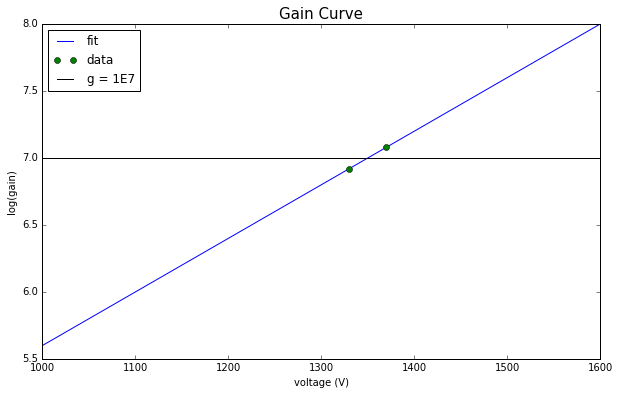

In [37]:
popt_gain, pcov_gain = curve_fit(gain_curve, voltages, np.log10(gain))
print(popt_gain)

x = np.arange(1000, 1600, 1)
gain_fit = gain_curve(x, *popt_gain) # log of the gain
# print(gain_fit)

plt.figure(figsize=(10,6))
plt.title('Gain Curve', fontsize=15)
plt.plot(x, gain_fit, label='fit')
plt.plot(voltages, np.log10(gain), marker='o', lw=0, label='data')
plt.plot(np.array([1000, 1600]), np.array([np.log10(1e7), np.log10(1e7)]), 'k-', label='g = 1E7')
plt.xlabel('voltage (V)')
plt.ylabel('log(gain)')
# plt.yscale('log')
plt.legend(loc='best')
# plt.savefig("gainCurve.png")

(7.0 - popt_gain[1])/popt_gain[0]